# 🎯 Feature Engineering Pipeline для EUR/USD

## 📋 Цель
Создать компактный MVP-набор из 33 признаков с единым неймингом (только `close` и признаки `f_*`) и сохранить результат в Parquet.

## 🎯 План выполнения
1. **Импорт библиотек и настройка**
2. **Загрузка и предобработка данных**
3. **Генерация базовых рядов (EMA, ATR, BB, KC, Donchian, MACD, ADX, PSAR, RSI)**
4. **Сборка финального набора `f_*` признаков**
5. **Обработка пропусков и сохранение**
6. **Аналитика и визуализация ключевых признаков**

## 📊 Ожидаемый результат
- **33 признака**: тренд, импульс, волатильность/диапазон, статистика доходностей и календарные факторы
- Единый формат имён: `f_<основа>_<параметры>` (например: `f_ema_20`, `f_ret_6`, `f_zscore_close_50`)


## 1. 📚 Импорт библиотек и настройка


In [1]:
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Надёжный поиск корня проекта: директория, где есть '03_src' и '01_data'

def _find_project_root(start: Path) -> Path:
    for base in [start] + list(start.parents):
        if (base / '03_src').exists() and (base / '01_data').exists():
            return base
    # fallback: ближайшая директория 'trading_predictor'
    for base in [start] + list(start.parents):
        if base.name == 'trading_predictor':
            return base
    return start

cwd = Path().resolve()
project_root = _find_project_root(cwd)

# Добавляем путь к исходникам
sys.path.append(str(project_root / '03_src'))

print(f"Корневая папка проекта: {project_root}")
print(f"Python version: {sys.version}")


Корневая папка проекта: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor
Python version: 3.12.0 (tags/v3.12.0:0fb18b0, Oct  2 2023, 13:03:39) [MSC v.1935 64 bit (AMD64)]


In [2]:
# Основные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import os

# Наши модули
try:
    from features import FeatureEngineeringPipeline  # type: ignore[reportMissingImports]
    
    print("✅ Модули feature engineering успешно импортированы")
except ImportError as e:
    print(f"❌ Ошибка импорта модулей: {e}")
    print("Убедитесь, что все файлы созданы в 03_src/features/")


✅ Модули feature engineering успешно импортированы


In [3]:
# Настройка отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# Настройка графиков
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Настройки применены")


✅ Настройки применены


## 2. 📊 Загрузка и предобработка данных


In [4]:
# Использование FeatureEngineeringPipeline для простого запуска
print("🚀 БЫСТРЫЙ СТАРТ С ПАЙПЛАЙНОМ")
print("=" * 40)

# Настраиваем правильные пути (запускаем из notebook, а пути в конфиге от корня проекта)
import os
from pathlib import Path
os.chdir(project_root)  # Меняем рабочую директорию на корень проекта
print(f"Текущая рабочая директория: {os.getcwd()}")
print(f"Проверка наличия '01_data': {os.path.exists(str(Path(project_root)/'01_data'))}")
print(f"Проверка наличия файла: {os.path.exists(str(Path(project_root)/'01_data'/'raw'/'EURUSD_2010-2024_H1_OANDA.csv'))}")

# Жёстко используем конкретный путь к файлу данных (без поиска любых CSV)
rel_path = Path("01_data/raw/EURUSD_2010-2024_H1_OANDA.csv")
full_path = (project_root / rel_path)
print(f"Путь к файлу (от корня): {full_path}")

data_file = str(full_path)
if full_path.exists():
    print(f"✅ Файл данных найден: {rel_path} -> {full_path}")
else:
    # Распечатаем содержимое raw для диагностики (первые 10 файлов)
    raw_dir = project_root / '01_data' / 'raw'
    try:
        listing = list(raw_dir.iterdir())[:10]
        print("Содержимое '01_data/raw' (первые 10):", [p.name for p in listing])
    except Exception as e:
        print(f"Не удалось прочитать директорию {raw_dir}: {e}")
    raise FileNotFoundError(
        f"Требуемый файл не найден по пути: {full_path}\n"
        f"Корень проекта: {project_root}"
    )

# Инициализация пайплайна
pipeline = FeatureEngineeringPipeline(profile="full")
print("✅ Pipeline инициализирован")

🚀 БЫСТРЫЙ СТАРТ С ПАЙПЛАЙНОМ
Текущая рабочая директория: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor
Проверка наличия '01_data': True
Проверка наличия файла: True
Путь к файлу (от корня): C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\01_data\raw\EURUSD_2010-2024_H1_OANDA.csv
✅ Файл данных найден: 01_data\raw\EURUSD_2010-2024_H1_OANDA.csv -> C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\01_data\raw\EURUSD_2010-2024_H1_OANDA.csv
✅ Pipeline инициализирован


In [5]:
# Запуск полного пайплайна с указанием файла
print("\nЗапуск полного Feature Engineering...")
df_with_features, stats = pipeline.run_full_pipeline(input_path=data_file)

print(f"\n🎯 КРАТКИЙ РЕЗУЛЬТАТ:")
print(f"✅ Pipeline завершен успешно!")
print(f"📊 Создано {stats['created_features']} новых признаков")
print(f"💾 Данные сохранены в Parquet формате")

2025-08-12 22:46:39 - FeatureEngineering - INFO - ============================================================
2025-08-12 22:46:39 - FeatureEngineering - INFO - STARTING FULL FEATURE ENGINEERING PIPELINE
2025-08-12 22:46:39 - FeatureEngineering - INFO - ============================================================
2025-08-12 22:46:39 - FeatureEngineering - INFO - Loading data from: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\01_data\raw\EURUSD_2010-2024_H1_OANDA.csv
2025-08-12 22:46:39 - FeatureEngineering - INFO - Data loaded successfully. Shape: (88630, 6)
2025-08-12 22:46:39 - FeatureEngineering - INFO - Validating and preparing data...
2025-08-12 22:46:39 - FeatureEngineering - INFO - Auto-mapped columns: {'time': 'Time', 'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}



Запуск полного Feature Engineering...


2025-08-12 22:46:40 - FeatureEngineering - INFO - Time column converted to datetime index
2025-08-12 22:46:40 - FeatureEngineering - INFO - Data validation completed. Final shape: (88630, 5)
2025-08-12 22:46:40 - FeatureEngineering - INFO - Starting MVP feature creation...
2025-08-12 22:46:40 - FeatureEngineering - INFO - Handling missing values...
2025-08-12 22:46:40 - FeatureEngineering - INFO - Initial missing values: 681 (0.02%)
2025-08-12 22:46:40 - FeatureEngineering - INFO - Filling missing values (keep_all mode)
2025-08-12 22:46:40 - FeatureEngineering - INFO - Final missing values: 0 (0.00%)
2025-08-12 22:46:40 - FeatureEngineering - INFO - MVP features created in 0.65 seconds
2025-08-12 22:46:40 - FeatureEngineering - INFO - Final feature set shape: (88630, 33)
2025-08-12 22:46:40 - FeatureEngineering - INFO - Saving results...
2025-08-12 22:46:40 - FeatureEngineering - INFO - Full dataset saved to: 01_data/processed/eurusd_features.parquet
2025-08-12 22:46:40 - FeatureEngine


🎯 КРАТКИЙ РЕЗУЛЬТАТ:
✅ Pipeline завершен успешно!
📊 Создано 33 новых признаков
💾 Данные сохранены в Parquet формате


In [6]:
# 🧩 Создание целевой переменной y_bhs (buy/hold/sell)
print("🧩 СОЗДАНИЕ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ y_bhs (MVP)")
print("=" * 60)

from features import create_bhs_labels  # type: ignore[reportMissingImports]

# Гарантируем наличие df_with_features и pipeline
try:
    df_with_features
except NameError:
    raise RuntimeError("Переменная df_with_features не найдена. Сначала выполните блок создания признаков")

try:
    pipeline
except NameError:
    raise RuntimeError("Переменная pipeline не найдена. Перезапустите ячейку с инициализацией пайплайна")

# Загружаем исходный OHLC для расчёта ATR и (опционально) спрэда
raw_df = pipeline.load_data(data_file)

# Создание меток y_bhs без утечки будущего
labels_df = create_bhs_labels(
    close=df_with_features['close'],
    df_ohlc=raw_df,           # для ATR(14) и (если есть) колонки Spread
    horizon=5,
    atr_period=14,
    eps_atr_multiplier=0.2,
    spread=None,              # если None — попробует взять Spread из raw_df, иначе 0
    return_debug=True         # добавит f_ret_h, f_atr, f_dead_eps
)

# Присоединяем к датасету признаков
cols_to_add = ['f_ret_h', 'f_atr', 'f_dead_eps', 'y_bhs']
cols_to_add = [c for c in cols_to_add if c in labels_df.columns]
df_with_features = df_with_features.join(labels_df[cols_to_add])

# Быстрая проверка
print("Горизонт H=5; последние H строк без меток (NaN)")
print("Распределение меток (с учётом NaN в хвосте):")
print(df_with_features['y_bhs'].value_counts(dropna=False).sort_index())

# Перезаписываем основной parquet с целевой переменной
out_path = '01_data/processed/eurusd_features.parquet'
try:
    df_with_features.to_parquet(out_path, engine='pyarrow', compression='snappy', index=True)
    print(f"💾 Перезаписан файл с целью: {out_path}")
except Exception as e:
    print(f"⚠️ Не удалось сохранить parquet с целью: {e}")


print("✅ y_bhs добавлена и сохранена в основном parquet")


2025-08-12 22:46:40 - FeatureEngineering - INFO - Loading data from: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\01_data\raw\EURUSD_2010-2024_H1_OANDA.csv
2025-08-12 22:46:41 - FeatureEngineering - INFO - Data loaded successfully. Shape: (88630, 6)
2025-08-12 22:46:41 - FeatureEngineering - INFO - Validating and preparing data...
2025-08-12 22:46:41 - FeatureEngineering - INFO - Auto-mapped columns: {'time': 'Time', 'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}


🧩 СОЗДАНИЕ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ y_bhs (MVP)


2025-08-12 22:46:41 - FeatureEngineering - INFO - Time column converted to datetime index
2025-08-12 22:46:41 - FeatureEngineering - INFO - Data validation completed. Final shape: (88630, 5)


Горизонт H=5; последние H строк без меток (NaN)
Распределение меток (с учётом NaN в хвосте):
y_bhs
0       37784
1       13071
2       37770
<NA>        5
Name: count, dtype: Int64
💾 Перезаписан файл с целью: 01_data/processed/eurusd_features.parquet
✅ y_bhs добавлена и сохранена в основном parquet


## 3. 📈 Анализ созданных признаков


In [7]:
# Детальный анализ созданных признаков (MVP набор `f_*`)
print("📊 АНАЛИЗ СОЗДАННЫХ ПРИЗНАКОВ (MVP)")
print("=" * 40)

# Базовая информация
print(f"Форма данных: {df_with_features.shape}")
print(f"Период данных: {df_with_features.index.min()} до {df_with_features.index.max()}")
print(f"Размер в памяти: {df_with_features.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Анализ по типам признаков (новый нейминг)
base_cols = ['close']
ema_cols = [c for c in df_with_features.columns if c in ['f_ema_10','f_ema_20','f_ema_50','f_ema_200']]
trend_cols = [
    'f_close_minus_ema_20_over_atr14','f_ema20_slope','f_macd_12_26_9_hist','f_di_diff_14','f_adx_14'
]
momentum_cols = ['f_rsi_5','f_rsi_14','f_roc_5']
vol_cols = [
    'f_atr_14_pct','f_return_std_20','f_range_over_atr','f_donchian_pos_20','f_keltner_pos_20','f_percentB_20','f_bandwidth_20'
]
ret_stats_cols = [
    'f_ret_1','f_ret_6','f_ret_12','f_ret_24','f_ret_1_z20','f_rolling_mean_ret_5','f_rolling_std_ret_5','f_zscore_close_50'
]
other_cols = ['f_vwap_dev_over_atr14','f_psar_trend']
calendar_cols = ['f_hour_of_day_sin','f_hour_of_day_cos','f_dow']

groups = {
    'База (close)': base_cols,
    'EMA': ema_cols,
    'Тренд': trend_cols,
    'Импульс': momentum_cols,
    'Волатильность/Диапазон': vol_cols,
    'Доходности/Статистика': ret_stats_cols,
    'Прочие': other_cols,
    'Календарные': calendar_cols,
}

print("\n📋 ТИПЫ ПРИЗНАКОВ:")
for name, cols in groups.items():
    existing = [c for c in cols if c in df_with_features.columns]
    print(f"{name}: {len(existing)}")

print(f"Итого колонок: {len(df_with_features.columns)}")

# Проверка качества данных
missing_count = df_with_features.isnull().sum().sum()
fill_pct = ((df_with_features.size - missing_count) / df_with_features.size) * 100
print(f"\n🔍 КАЧЕСТВО ДАННЫХ:")
print(f"Пропущенные значения: {missing_count:,}")
print(f"Процент заполненности: {fill_pct:.2f}%")


📊 АНАЛИЗ СОЗДАННЫХ ПРИЗНАКОВ (MVP)
Форма данных: (88630, 37)
Период данных: 2010-01-03 17:00:00+00:00 до 2023-12-29 21:00:00+00:00
Размер в памяти: 26.53 MB

📋 ТИПЫ ПРИЗНАКОВ:
База (close): 1
EMA: 4
Тренд: 5
Импульс: 3
Волатильность/Диапазон: 7
Доходности/Статистика: 8
Прочие: 2
Календарные: 3
Итого колонок: 37

🔍 КАЧЕСТВО ДАННЫХ:
Пропущенные значения: 10
Процент заполненности: 100.00%


## 🔍 Анализ Missing Values

Детальный анализ пропущенных значений в созданном датасете для принятия решения о дальнейшей обработке.


In [8]:
# Детальный анализ Missing Values (MVP фичи)
print("🔍 АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ (MVP)")
print("=" * 50)

# Общая статистика
total_values = df_with_features.size
missing_values = df_with_features.isnull().sum().sum()
missing_percentage = (missing_values / total_values) * 100

print(f"📊 Общая статистика:")
print(f"  • Всего значений: {total_values:,}")
print(f"  • Пропущенных значений: {missing_values:,}")
print(f"  • Процент пропусков: {missing_percentage:.2f}%")

# Анализ по строкам
rows_with_missing = df_with_features.isnull().any(axis=1).sum()
complete_rows = len(df_with_features) - rows_with_missing

print(f"\n📈 Анализ по строкам:")
print(f"  • Полные строки (без NaN): {complete_rows:,}")
print(f"  • Строки с пропусками: {rows_with_missing:,}")
print(f"  • Процент полных строк: {(complete_rows/len(df_with_features)*100):.2f}%")

# Анализ по группам (новый нейминг)
f_groups = {
    'База (close)': ['close'],
    'EMA': ['f_ema_10','f_ema_20','f_ema_50','f_ema_200'],
    'Тренд': ['f_close_minus_ema_20_over_atr14','f_ema20_slope','f_macd_12_26_9_hist','f_di_diff_14','f_adx_14'],
    'Импульс': ['f_rsi_5','f_rsi_14','f_roc_5'],
    'Волатильность/Диапазон': ['f_atr_14_pct','f_return_std_20','f_range_over_atr','f_donchian_pos_20','f_keltner_pos_20','f_percentB_20','f_bandwidth_20'],
    'Доходности/Статистика': ['f_ret_1','f_ret_6','f_ret_12','f_ret_24','f_ret_1_z20','f_rolling_mean_ret_5','f_rolling_std_ret_5','f_zscore_close_50'],
    'Прочие': ['f_vwap_dev_over_atr14','f_psar_trend'],
    'Календарные': ['f_hour_of_day_sin','f_hour_of_day_cos','f_dow'],
}

print(f"\n🎯 Анализ по типам признаков:")
for group_name, columns in f_groups.items():
    columns = [c for c in columns if c in df_with_features.columns]
    if columns:
        group_missing = df_with_features[columns].isnull().sum().sum()
        group_total = len(columns) * len(df_with_features)
        group_percentage = (group_missing / max(group_total, 1)) * 100
        print(f"  • {group_name}: {group_missing:,}/{group_total:,} ({group_percentage:.2f}%)")

# Топ-10 колонок с наибольшим количеством пропусков
print(f"\n🔝 Топ-10 признаков с наибольшим количеством пропусков:")
missing_by_column = df_with_features.isnull().sum().sort_values(ascending=False)
missing_by_column = missing_by_column[missing_by_column > 0]
print(missing_by_column.head(10))

# Анализ по временным периодам
print(f"\n⏰ Анализ по временным периодам:")
# Первые 1000 строк (начало периода)
early_missing = df_with_features.head(1000).isnull().sum().sum()
early_total = 1000 * df_with_features.shape[1]
early_percentage = (early_missing / max(early_total, 1)) * 100

# Последние 1000 строк (конец периода)
late_missing = df_with_features.tail(1000).isnull().sum().sum()
late_total = 1000 * df_with_features.shape[1]
late_percentage = (late_missing / max(late_total, 1)) * 100

print(f"  • Первые 1000 строк: {early_missing:,}/{early_total:,} ({early_percentage:.2f}%)")
print(f"  • Последние 1000 строк: {late_missing:,}/{late_total:,} ({late_percentage:.2f}%)")

# Рекомендации
print(f"\n💡 РЕКОМЕНДАЦИИ:")
if missing_percentage < 5:
    print("  ✅ Низкий уровень пропусков (<5%) - можно удалить строки с NaN")
elif missing_percentage < 15:
    print("  ⚠️  Средний уровень пропусков (5-15%) - рассмотрите forward fill")
else:
    print("  🔥 Высокий уровень пропусков (>15%) - требуется детальный анализ")

if early_percentage > late_percentage * 2:
    print("  📊 Большинство пропусков в начале - нормально для технических индикаторов")
    print("  💡 Можно удалить первые N строк где слишком много NaN")

print(f"\n🎯 Готов для дальнейшего анализа и принятия решения!")


🔍 АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ (MVP)
📊 Общая статистика:
  • Всего значений: 3,279,310
  • Пропущенных значений: 10
  • Процент пропусков: 0.00%

📈 Анализ по строкам:
  • Полные строки (без NaN): 88,625
  • Строки с пропусками: 5
  • Процент полных строк: 99.99%

🎯 Анализ по типам признаков:
  • База (close): 0/88,630 (0.00%)
  • EMA: 0/354,520 (0.00%)
  • Тренд: 0/443,150 (0.00%)
  • Импульс: 0/265,890 (0.00%)
  • Волатильность/Диапазон: 0/620,410 (0.00%)
  • Доходности/Статистика: 0/709,040 (0.00%)
  • Прочие: 0/177,260 (0.00%)
  • Календарные: 0/265,890 (0.00%)

🔝 Топ-10 признаков с наибольшим количеством пропусков:
y_bhs      5
f_ret_h    5
dtype: int64

⏰ Анализ по временным периодам:
  • Первые 1000 строк: 0/37,000 (0.00%)
  • Последние 1000 строк: 10/37,000 (0.03%)

💡 РЕКОМЕНДАЦИИ:
  ✅ Низкий уровень пропусков (<5%) - можно удалить строки с NaN

🎯 Готов для дальнейшего анализа и принятия решения!


## 🧹 Очистка датасета от строк с NaN

Удаление всех строк, содержащих хотя бы одно пропущенное значение, и повторная проверка качества данных.


In [9]:
print("🧹 ОЧИСТКА ДАТАСЕТА ОТ СТРОК С NaN")
print("=" * 50)

# Загружаем сохранённый датасет
parquet_path = "01_data/processed/eurusd_features.parquet"
print(f"📂 Загрузка: {parquet_path}")

df_original = pd.read_parquet(parquet_path)
print(f"✅ Загружен оригинальный датасет: {df_original.shape}")

# Статистика ПЕРЕД очисткой
original_missing = df_original.isnull().sum().sum()
original_total = df_original.shape[0] * df_original.shape[1]
original_missing_pct = (original_missing / original_total) * 100

print(f"\n📊 СТАТИСТИКА ПЕРЕД ОЧИСТКОЙ:")
print(f"  • Общий размер: {df_original.shape}")
print(f"  • Пропущенные значения: {original_missing:,}")
print(f"  • Процент пропусков: {original_missing_pct:.2f}%")
print(f"  • Строки с пропусками: {df_original.isnull().any(axis=1).sum():,}")

# ОЧИСТКА: удаляем строки с любыми NaN
print(f"\n🔥 ВЫПОЛНЯЕТСЯ ОЧИСТКА...")
df_cleaned = df_original.dropna()

# Статистика ПОСЛЕ очистки
cleaned_missing = df_cleaned.isnull().sum().sum()
cleaned_total = df_cleaned.shape[0] * df_cleaned.shape[1]
cleaned_missing_pct = (cleaned_missing / cleaned_total) * 100

print(f"\n📊 СТАТИСТИКА ПОСЛЕ ОЧИСТКИ:")
print(f"  • Общий размер: {df_cleaned.shape}")
print(f"  • Пропущенные значения: {cleaned_missing:,}")
print(f"  • Процент пропусков: {cleaned_missing_pct:.2f}%")
print(f"  • Удалено строк: {len(df_original) - len(df_cleaned):,}")
print(f"  • Сохранено строк: {len(df_cleaned):,} ({len(df_cleaned)/len(df_original)*100:.2f}%)")

# Перезаписываем оригинальный файл очищенным датасетом
print(f"\n💾 СОХРАНЕНИЕ ОЧИЩЕННОГО ДАТАСЕТА...")
df_cleaned.to_parquet(parquet_path)
print(f"✅ Перезаписан файл: {parquet_path}")

# ФИНАЛЬНАЯ ПРОВЕРКА КАЧЕСТВА ДАННЫХ
print(f"\n🔍 КАЧЕСТВО ДАННЫХ:")
final_missing = df_cleaned.isnull().sum().sum()
final_total = df_cleaned.shape[0] * df_cleaned.shape[1]
final_missing_pct = (final_missing / final_total) * 100

print(f"Пропущенные значения: {final_missing:,}")
print(f"Процент заполненности: {100 - final_missing_pct:.2f}%")

print(f"\n🎯 ГОТОВО! Датасет очищен и готов к использованию!")

# Обновляем переменную df_with_features для дальнейшего использования
df_with_features = df_cleaned.copy()
print(f"📊 Переменная df_with_features обновлена: {df_with_features.shape}")


🧹 ОЧИСТКА ДАТАСЕТА ОТ СТРОК С NaN
📂 Загрузка: 01_data/processed/eurusd_features.parquet
✅ Загружен оригинальный датасет: (88630, 37)

📊 СТАТИСТИКА ПЕРЕД ОЧИСТКОЙ:
  • Общий размер: (88630, 37)
  • Пропущенные значения: 10
  • Процент пропусков: 0.00%
  • Строки с пропусками: 5

🔥 ВЫПОЛНЯЕТСЯ ОЧИСТКА...

📊 СТАТИСТИКА ПОСЛЕ ОЧИСТКИ:
  • Общий размер: (88625, 37)
  • Пропущенные значения: 0
  • Процент пропусков: 0.00%
  • Удалено строк: 5
  • Сохранено строк: 88,625 (99.99%)

💾 СОХРАНЕНИЕ ОЧИЩЕННОГО ДАТАСЕТА...
✅ Перезаписан файл: 01_data/processed/eurusd_features.parquet

🔍 КАЧЕСТВО ДАННЫХ:
Пропущенные значения: 0
Процент заполненности: 100.00%

🎯 ГОТОВО! Датасет очищен и готов к использованию!
📊 Переменная df_with_features обновлена: (88625, 37)


📈 ВИЗУАЛИЗАЦИЯ КЛЮЧЕВЫХ ПРИЗНАКОВ (MVP)
💾 Сохранено: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\01_data\interim\images\feature_analysis\fig_ключевые_признаки_20250812_224642.png


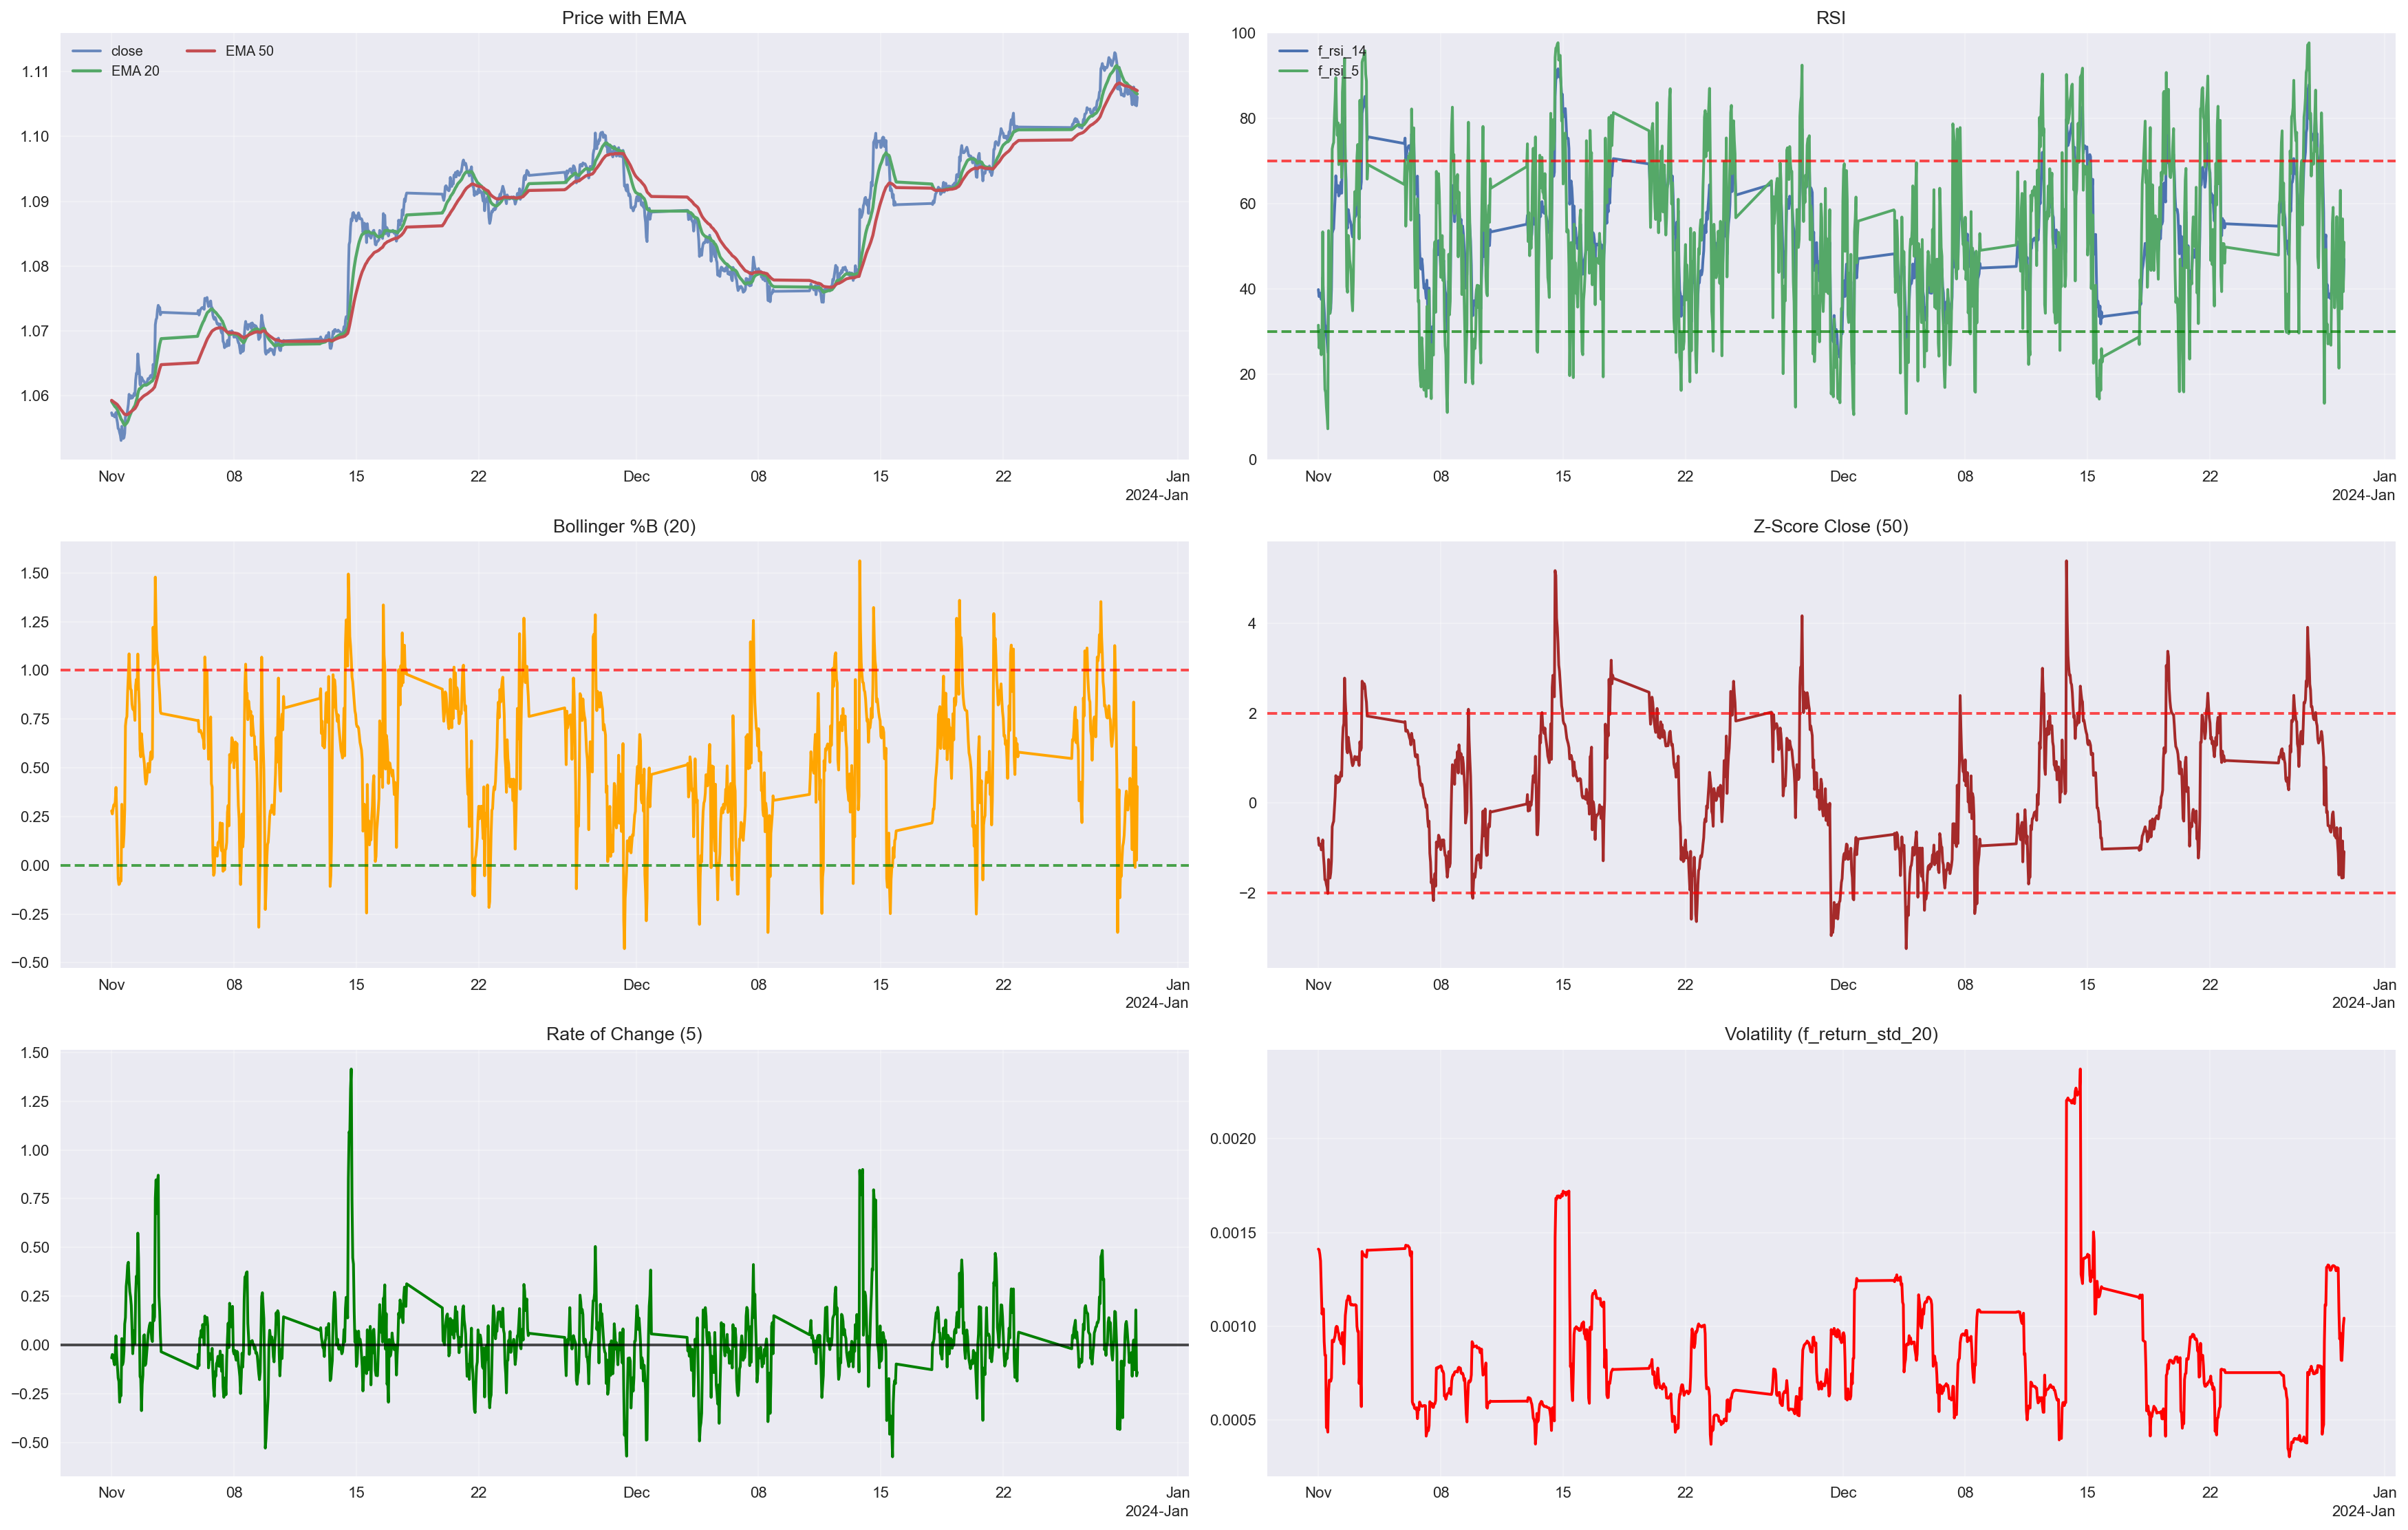

In [10]:
# Визуализация ключевых признаков (MVP `f_*`)
print("📈 ВИЗУАЛИЗАЦИЯ КЛЮЧЕВЫХ ПРИЗНАКОВ (MVP)")

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from pathlib import Path

# Гарантируем наличие df_with_features (подгружаем из parquet при холодном запуске ядра)
try:
    df_with_features
except NameError:
    def _find_processed_parquet():
        cwd = Path().resolve()
        candidates = ['eurusd_features.parquet', 'eurusd_features_demo.parquet']
        for base in [cwd] + list(cwd.parents):
            processed_dir = base / '01_data' / 'processed'
            if processed_dir.exists():
                for name in candidates:
                    p = processed_dir / name
                    if p.exists():
                        return p
        return None
    parquet_file = _find_processed_parquet()
    if parquet_file is None:
        raise FileNotFoundError("Не найден parquet в '01_data/processed'. Сначала выполните пайплайн или укажите путь вручную.")
    df_with_features = pd.read_parquet(parquet_file)
    print(f"ℹ️ Загружен датасет: {parquet_file} {df_with_features.shape}")

# Выберем последние 1000 записей для лучшей видимости
plot_data = df_with_features.tail(1000)

fig, axes = plt.subplots(3, 2, figsize=(22, 14), dpi=160)

date_locator = mdates.AutoDateLocator()
date_formatter = mdates.ConciseDateFormatter(date_locator)

# 1. Цена с EMA
axes[0,0].plot(plot_data.index, plot_data['close'], label='close', alpha=0.8, linewidth=1.8)
for ema_col, label in [('f_ema_20','EMA 20'), ('f_ema_50','EMA 50')]:
    if ema_col in plot_data.columns:
        axes[0,0].plot(plot_data.index, plot_data[ema_col], label=label, linewidth=2.0)
axes[0,0].set_title('Price with EMA')
axes[0,0].legend(loc='upper left', fontsize=9, ncol=2)
axes[0,0].grid(True, alpha=0.3)
axes[0,0].xaxis.set_major_locator(date_locator)
axes[0,0].xaxis.set_major_formatter(date_formatter)
axes[0,0].tick_params(axis='x', rotation=0)

# 2. RSI
for rsi_col, ttl in [('f_rsi_14','RSI (14)'), ('f_rsi_5','RSI (5)')]:
    if rsi_col in plot_data.columns:
        axes[0,1].plot(plot_data.index, plot_data[rsi_col], linewidth=1.8, label=rsi_col)
axes[0,1].axhline(y=70, color='r', linestyle='--', alpha=0.7)
axes[0,1].axhline(y=30, color='g', linestyle='--', alpha=0.7)
axes[0,1].set_title('RSI')
axes[0,1].set_ylim(0, 100)
axes[0,1].legend(loc='upper left', fontsize=9)
axes[0,1].grid(True, alpha=0.3)
axes[0,1].xaxis.set_major_locator(date_locator)
axes[0,1].xaxis.set_major_formatter(date_formatter)
axes[0,1].tick_params(axis='x', rotation=0)

# 3. Bollinger %B (f_percentB_20)
if 'f_percentB_20' in plot_data.columns:
    axes[1,0].plot(plot_data.index, plot_data['f_percentB_20'], color='orange', linewidth=1.8)
    axes[1,0].axhline(y=1, color='r', linestyle='--', alpha=0.7)
    axes[1,0].axhline(y=0, color='g', linestyle='--', alpha=0.7)
    axes[1,0].set_title('Bollinger %B (20)')
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].xaxis.set_major_locator(date_locator)
    axes[1,0].xaxis.set_major_formatter(date_formatter)
    axes[1,0].tick_params(axis='x', rotation=0)

# 4. Z-Score close (50)
if 'f_zscore_close_50' in plot_data.columns:
    axes[1,1].plot(plot_data.index, plot_data['f_zscore_close_50'], color='brown', linewidth=1.8)
    axes[1,1].axhline(y=2, color='r', linestyle='--', alpha=0.7)
    axes[1,1].axhline(y=-2, color='r', linestyle='--', alpha=0.7)
    axes[1,1].set_title('Z-Score Close (50)')
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].xaxis.set_major_locator(date_locator)
    axes[1,1].xaxis.set_major_formatter(date_formatter)
    axes[1,1].tick_params(axis='x', rotation=0)

# 5. ROC 5
if 'f_roc_5' in plot_data.columns:
    axes[2,0].plot(plot_data.index, plot_data['f_roc_5'], color='green', linewidth=1.8)
    axes[2,0].axhline(y=0, color='black', linestyle='-', alpha=0.7)
    axes[2,0].set_title('Rate of Change (5)')
    axes[2,0].grid(True, alpha=0.3)
    axes[2,0].xaxis.set_major_locator(date_locator)
    axes[2,0].xaxis.set_major_formatter(date_formatter)
    axes[2,0].tick_params(axis='x', rotation=0)

# 6. Волатильность: std лог-ретёрнов 20 или ATR%14
vol_col = None
for col in ['f_return_std_20', 'f_atr_14_pct']:
    if col in plot_data.columns:
        vol_col = col
        break

if vol_col:
    axes[2,1].plot(plot_data.index, plot_data[vol_col], color='red', linewidth=1.8)
    axes[2,1].set_title(f'Volatility ({vol_col})')
    axes[2,1].grid(True, alpha=0.3)
    axes[2,1].xaxis.set_major_locator(date_locator)
    axes[2,1].xaxis.set_major_formatter(date_formatter)
    axes[2,1].tick_params(axis='x', rotation=0)

# Сохранение графика в images/feature_analysis
images_base = Path(project_root) / '01_data' / 'interim' / 'images'
features_dir = images_base / 'feature_analysis'
features_dir.mkdir(parents=True, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
fig_path = features_dir / f"fig_ключевые_признаки_{timestamp}.png"

plt.tight_layout()
plt.savefig(fig_path, dpi=160, bbox_inches='tight')
print(f"💾 Сохранено: {fig_path}")
plt.show()


🔗 КОРРЕЛЯЦИОННЫЙ АНАЛИЗ


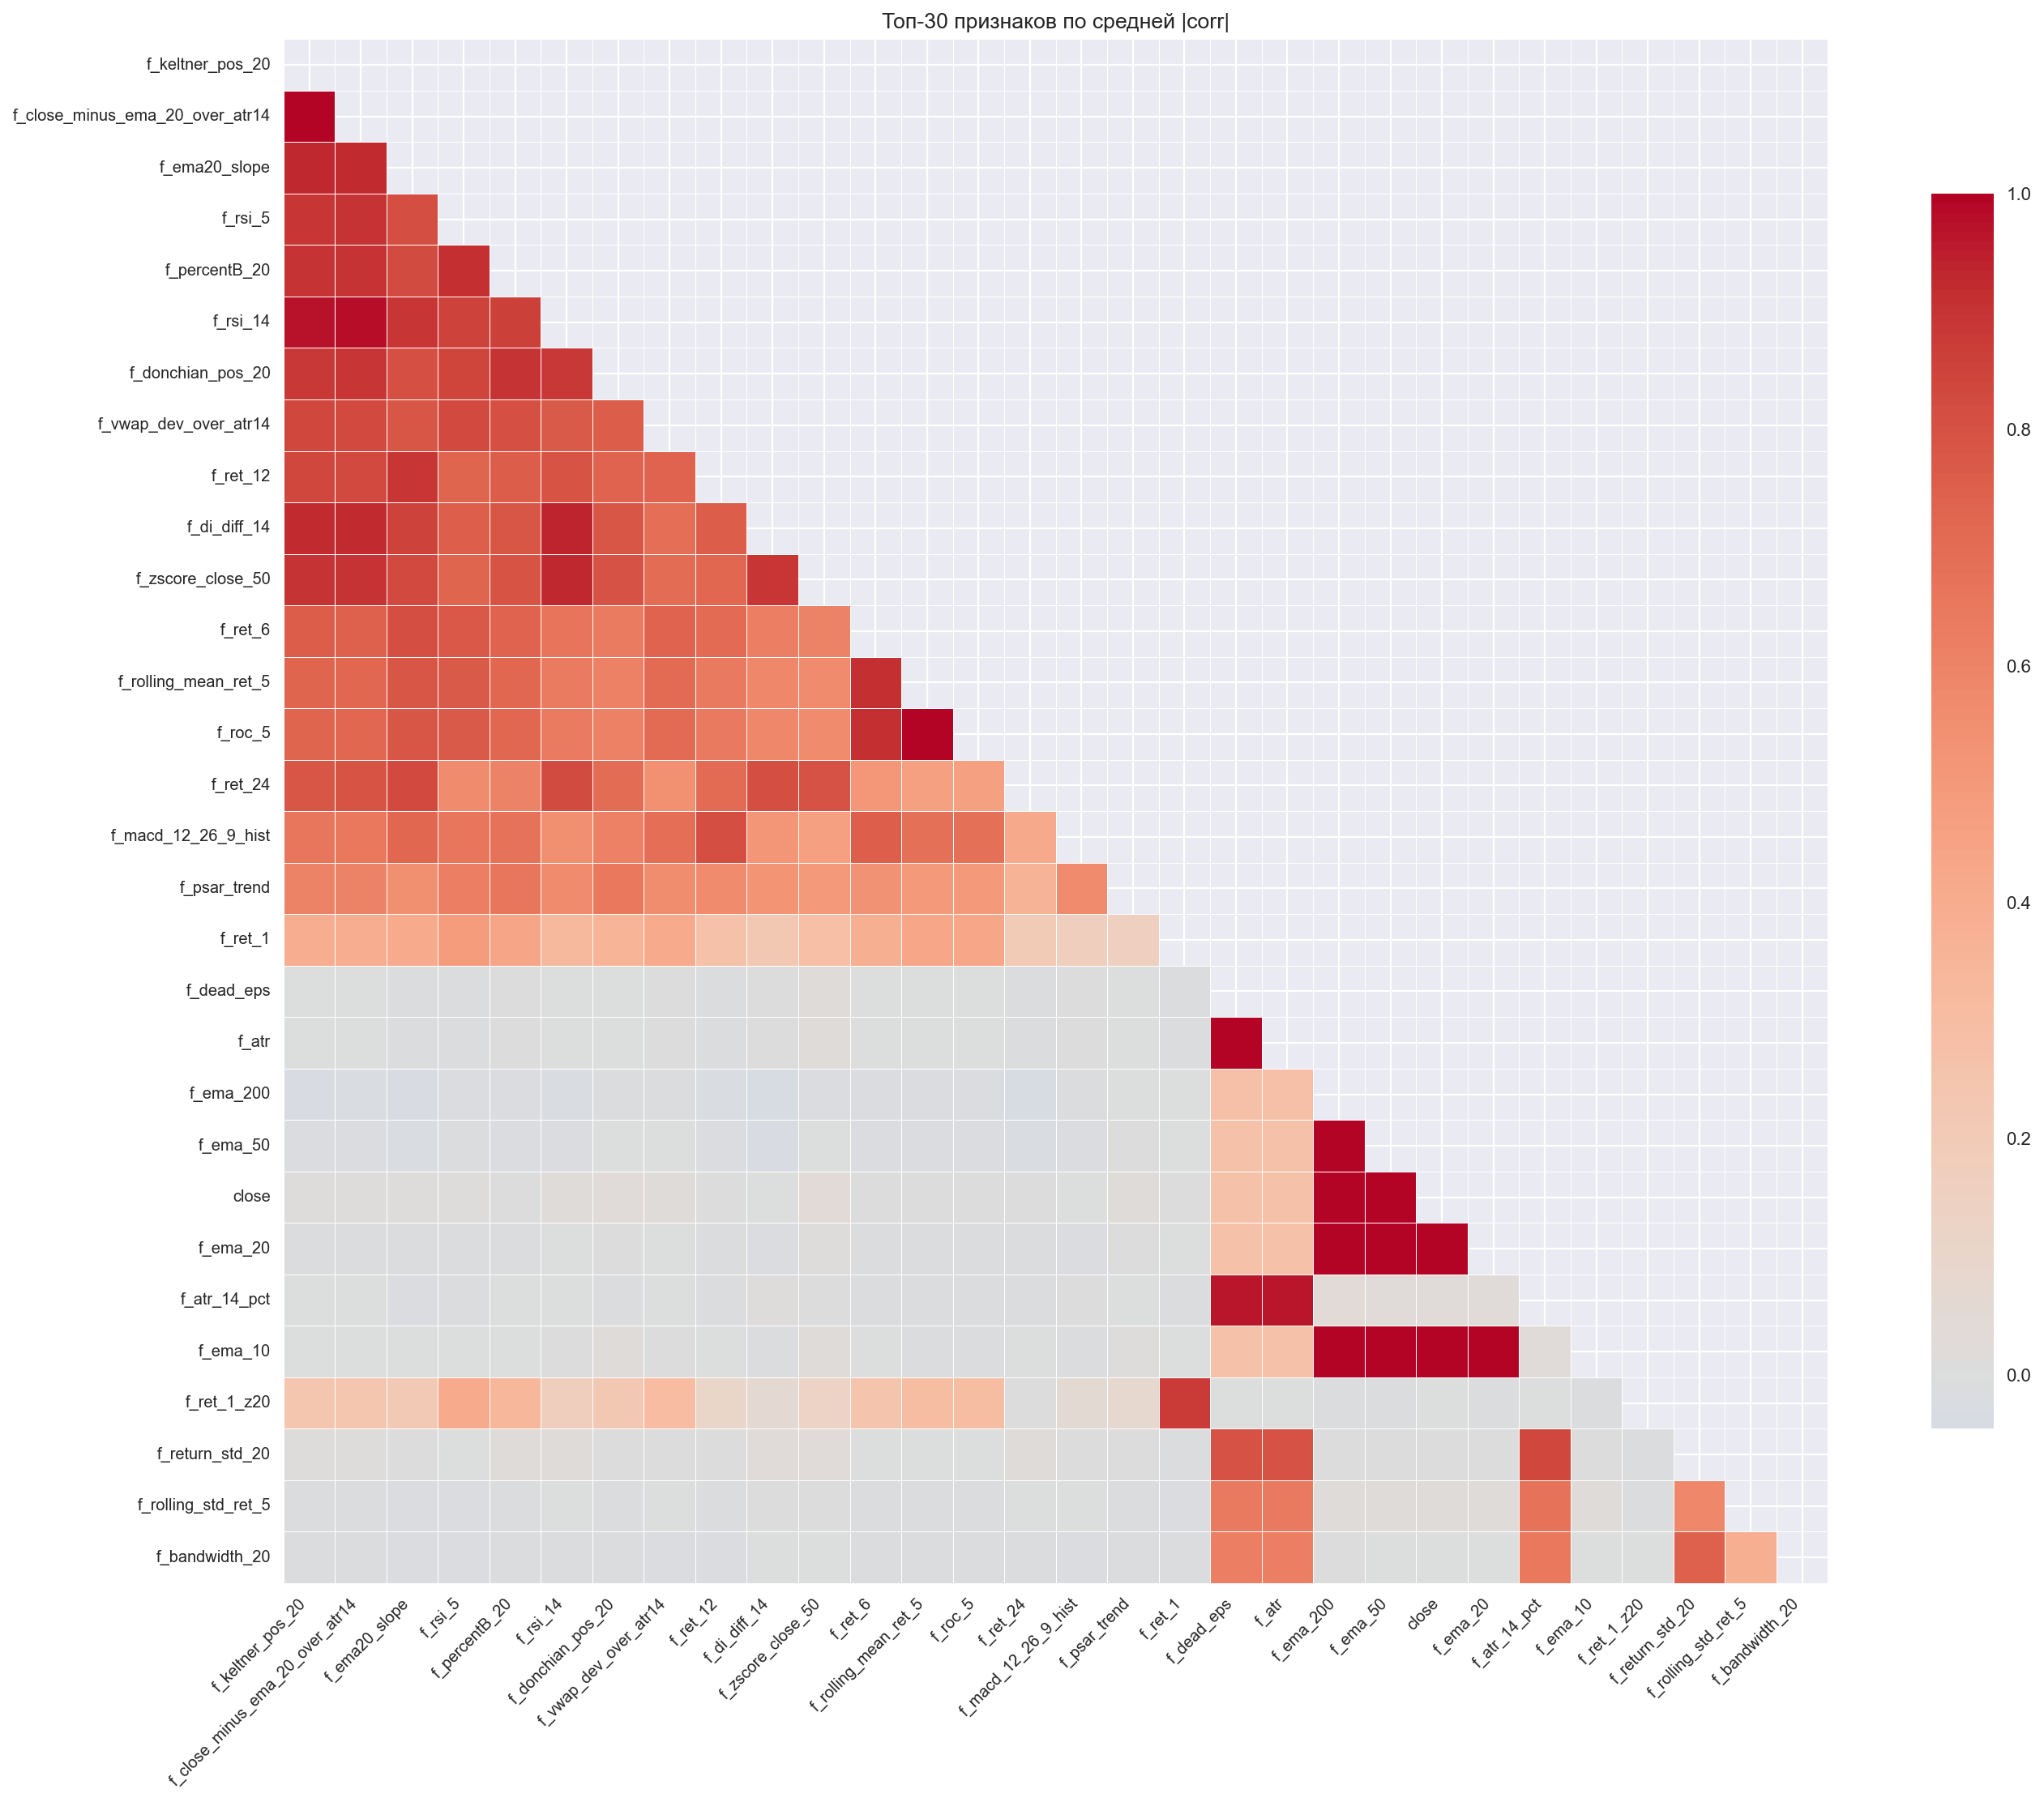

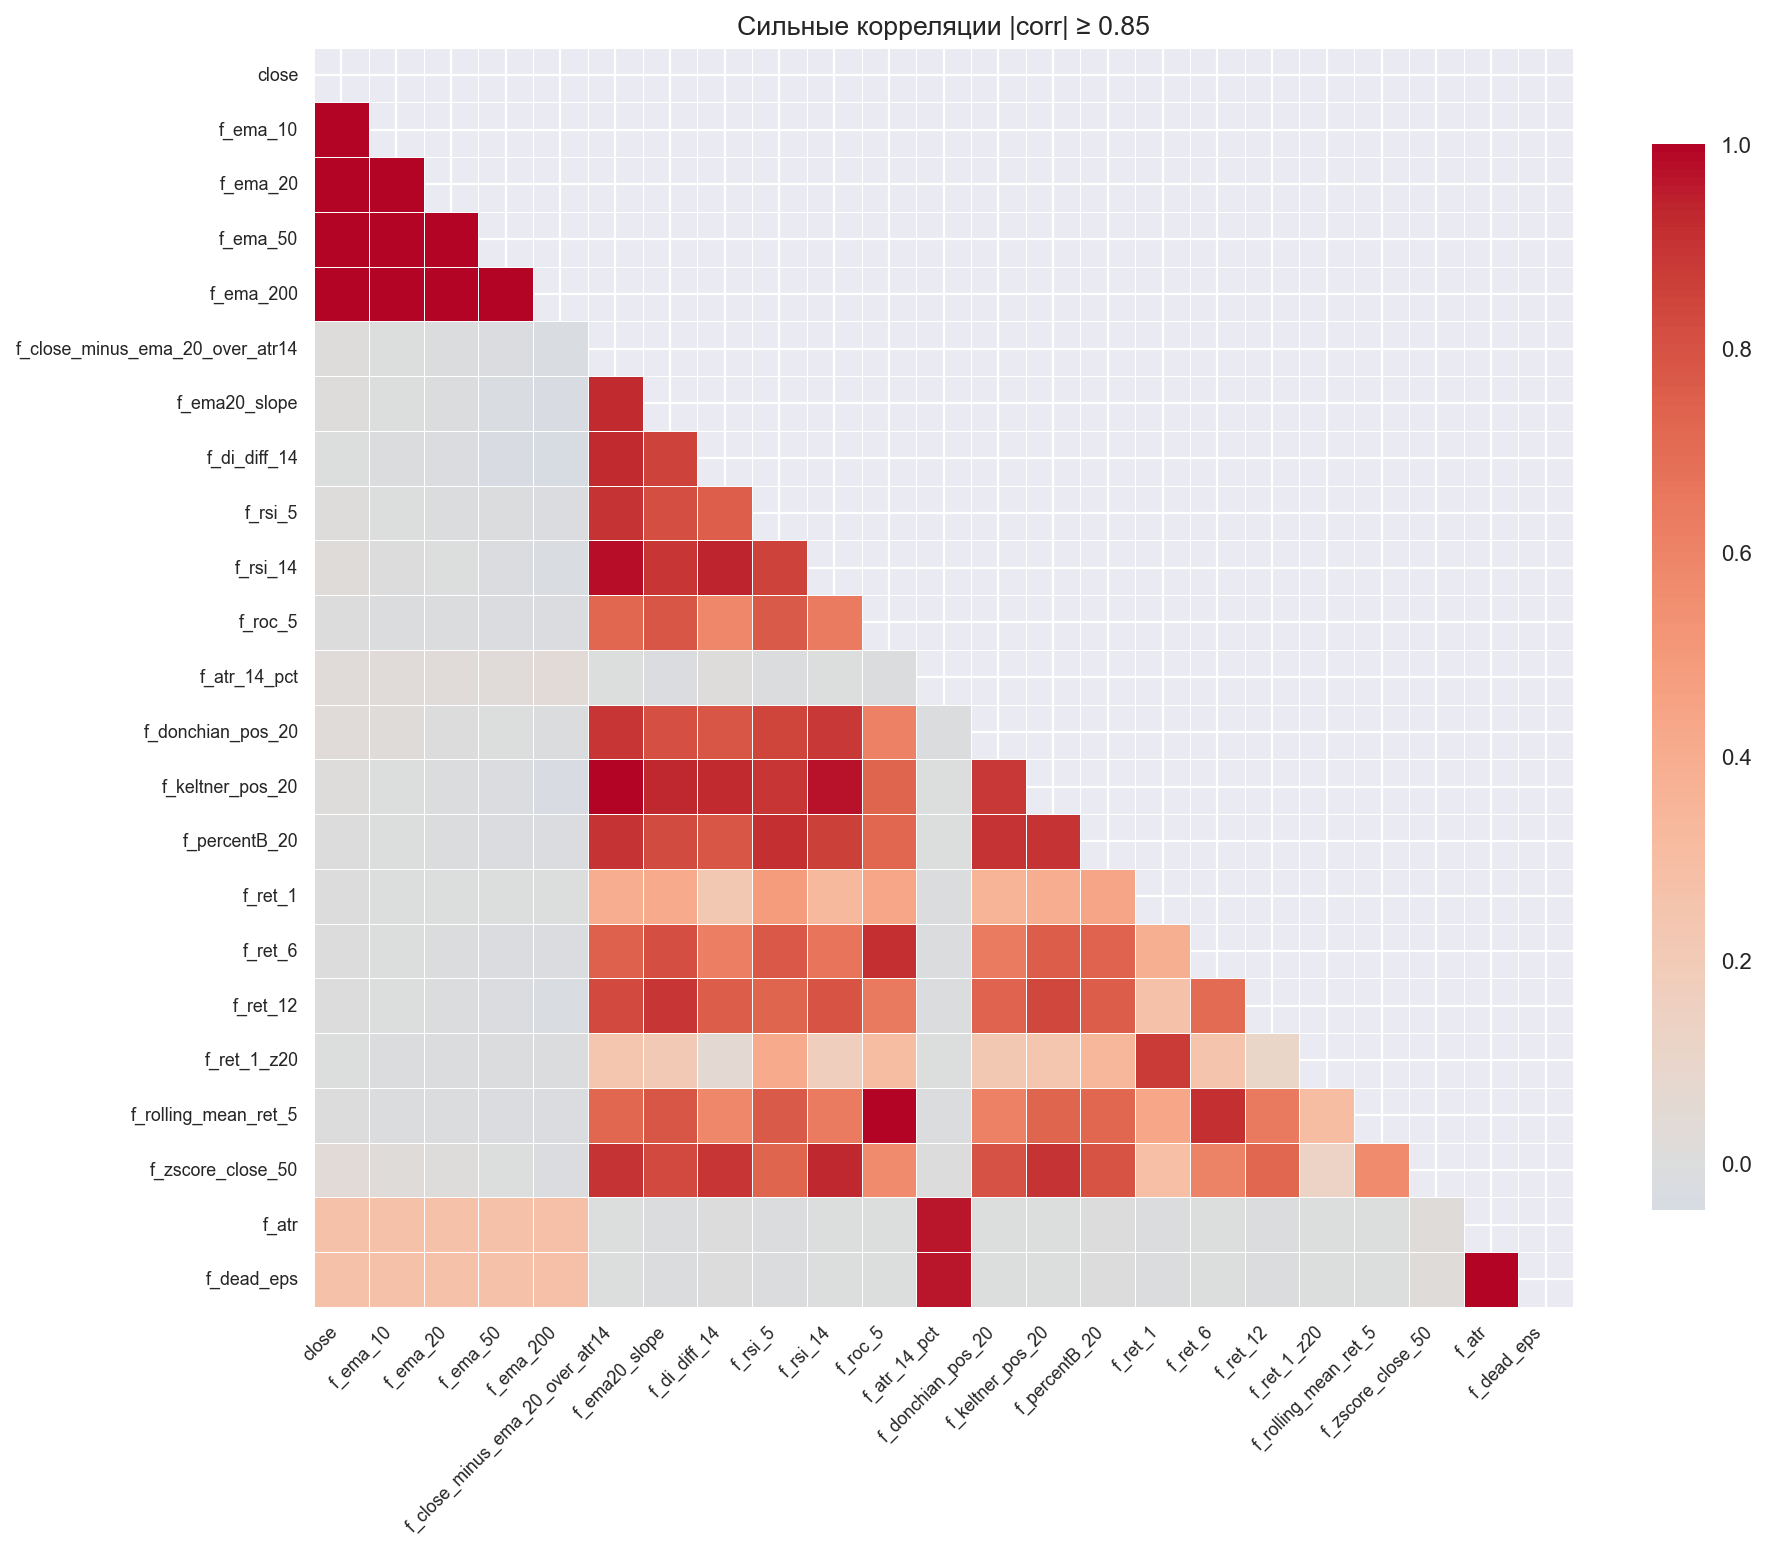


Топ-50 коррелирующих пар (по |corr|):
  f_atr ↔ f_dead_eps: 1.000
  f_roc_5 ↔ f_rolling_mean_ret_5: 1.000
  f_ema_10 ↔ f_ema_20: 1.000
  close ↔ f_ema_10: 1.000
  f_ema_20 ↔ f_ema_50: 1.000
  close ↔ f_ema_20: 1.000
  f_ema_10 ↔ f_ema_50: 1.000
  close ↔ f_ema_50: 0.999
  f_ema_50 ↔ f_ema_200: 0.999
  f_close_minus_ema_20_over_atr14 ↔ f_keltner_pos_20: 0.999
  f_ema_20 ↔ f_ema_200: 0.998
  f_ema_10 ↔ f_ema_200: 0.997
  close ↔ f_ema_200: 0.997
  f_close_minus_ema_20_over_atr14 ↔ f_rsi_14: 0.978
  f_rsi_14 ↔ f_keltner_pos_20: 0.972
  f_atr_14_pct ↔ f_dead_eps: 0.964
  f_atr_14_pct ↔ f_atr: 0.964
  f_di_diff_14 ↔ f_rsi_14: 0.941
  f_ema20_slope ↔ f_keltner_pos_20: 0.930
  f_rsi_14 ↔ f_zscore_close_50: 0.929
  f_close_minus_ema_20_over_atr14 ↔ f_ema20_slope: 0.924
  f_close_minus_ema_20_over_atr14 ↔ f_di_diff_14: 0.922
  f_di_diff_14 ↔ f_keltner_pos_20: 0.919
  f_rsi_5 ↔ f_percentB_20: 0.912
  f_ret_6 ↔ f_rolling_mean_ret_5: 0.907
  f_roc_5 ↔ f_ret_6: 0.907
  f_close_minus_ema_20_over_at

In [11]:
# Корреляционный анализ (все признаки без "каши")
print("🔗 КОРРЕЛЯЦИОННЫЙ АНАЛИЗ")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Гарантируем наличие df_with_features (подгружаем из parquet при холодном запуске ядра)
try:
    df_with_features
except NameError:
    def _find_processed_parquet():
        cwd = Path().resolve()
        candidates = ['eurusd_features.parquet', 'eurusd_features_demo.parquet']
        for base in [cwd] + list(cwd.parents):
            processed_dir = base / '01_data' / 'processed'
            if processed_dir.exists():
                for name in candidates:
                    p = processed_dir / name
                    if p.exists():
                        return p
        return None
    parquet_file = _find_processed_parquet()
    if parquet_file is None:
        raise FileNotFoundError("Не найден parquet в '01_data/processed'. Сначала выполните пайплайн или укажите путь вручную.")
    df_with_features = pd.read_parquet(parquet_file)
    print(f"ℹ️ Загружен датасет: {parquet_file} {df_with_features.shape}")

# Берём только числовые признаки
numeric_df = df_with_features.select_dtypes(include=[np.number]).copy()

# Сэмплирование для ускорения (если очень большой набор)
if len(numeric_df) > 20000:
    numeric_df_sample = numeric_df.sample(20000, random_state=42)
else:
    numeric_df_sample = numeric_df

# Полная матрица корреляций
corr_full = numeric_df_sample.corr()

# 1) Обзор топ-30 признаков с наибольшей средней |corr| (кроме автокорреляции)
mean_abs_corr = corr_full.abs()
np.fill_diagonal(mean_abs_corr.values, np.nan)
mean_strength = mean_abs_corr.mean().sort_values(ascending=False)

top_n = 30
top_features = mean_strength.head(min(top_n, len(mean_strength))).index
corr_top = corr_full.loc[top_features, top_features]

plt.figure(figsize=(18, 14), dpi=160)
mask = np.triu(np.ones_like(corr_top, dtype=bool))
sns.heatmap(corr_top, mask=mask, cmap='coolwarm', center=0, square=True,
            linewidths=0.4, cbar_kws={"shrink": 0.8})
plt.title(f'Топ-{len(top_features)} признаков по средней |corr|')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()

# 2) Теплокарта только сильных связей (|corr| >= 0.85)
threshold = 0.85
strong_mask = mean_abs_corr >= threshold
np.fill_diagonal(strong_mask.values, False)
strong_cols = strong_mask.any(axis=0)
strong_rows = strong_mask.any(axis=1)

strong_features = mean_abs_corr.columns[strong_cols | strong_rows]

if len(strong_features) > 1:
    corr_strong = corr_full.loc[strong_features, strong_features]
    plt.figure(figsize=(max(12, 0.35*len(strong_features)), max(10, 0.35*len(strong_features))), dpi=160)
    mask = np.triu(np.ones_like(corr_strong, dtype=bool))
    sns.heatmap(corr_strong, mask=mask, cmap='coolwarm', center=0, square=True,
                linewidths=0.4, cbar_kws={"shrink": 0.8})
    plt.title(f'Сильные корреляции |corr| ≥ {threshold}')
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()
else:
    print(f"Сильные корреляции (|corr| ≥ {threshold}) не найдены.")

# 3) Таблица топ-50 пар по |corr|
pairs = []
cols = corr_full.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        pairs.append((cols[i], cols[j], corr_full.iloc[i, j]))

pairs_sorted = sorted(pairs, key=lambda x: abs(x[2]), reverse=True)
print("\nТоп-50 коррелирующих пар (по |corr|):")
for col1, col2, c in pairs_sorted[:50]:
    print(f"  {col1} ↔ {col2}: {c:.3f}")


In [12]:
# Сохранение графиков из корреляционного анализа в images/correlation_analysis
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Базовая папка изображений
images_base = Path(project_root) / '01_data' / 'interim' / 'images'
corr_dir = images_base / 'correlation_analysis'
corr_dir.mkdir(parents=True, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Если переменные не существуют (ячейка анализа не была выполнена), пересчитаем кратко
if not all(k in globals() for k in ('corr_full', 'mean_abs_corr', 'top_features')):
    import pandas as pd
    # гарантируем датасет
    if 'df_with_features' not in globals():
        from pathlib import Path as _P
        def _find_processed_parquet():
            cwd = _P().resolve()
            candidates = ['eurusd_features.parquet', 'eurusd_features_demo.parquet']
            for base in [cwd] + list(cwd.parents):
                processed_dir = base / '01_data' / 'processed'
                if processed_dir.exists():
                    for name in candidates:
                        p = processed_dir / name
                        if p.exists():
                            return p
            return None
        parquet_file = _find_processed_parquet()
        if parquet_file is None:
            raise FileNotFoundError("Не найден parquet в '01_data/processed'. Выполните пайплайн или укажите путь вручную.")
        df_with_features = pd.read_parquet(parquet_file)

    numeric_df = df_with_features.select_dtypes(include=[np.number]).copy()
    if len(numeric_df) > 20000:
        numeric_df_sample = numeric_df.sample(20000, random_state=42)
    else:
        numeric_df_sample = numeric_df
    corr_full = numeric_df_sample.corr()
    mean_abs_corr = corr_full.abs()
    np.fill_diagonal(mean_abs_corr.values, np.nan)
    mean_strength = mean_abs_corr.mean().sort_values(ascending=False)
    top_n = 30
    top_features = mean_strength.head(min(top_n, len(mean_strength))).index

# 1) Теплокарта топовых признаков
corr_top = corr_full.loc[top_features, top_features]
plt.figure(figsize=(18, 14), dpi=160)
mask = np.triu(np.ones_like(corr_top, dtype=bool))
sns.heatmap(corr_top, mask=mask, cmap='coolwarm', center=0, square=True,
            linewidths=0.4, cbar_kws={"shrink": 0.8})
plt.title(f'Топ-{len(top_features)} признаков по средней |corr|')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
fig1_path = corr_dir / f"fig_corr_top_{len(top_features)}_{timestamp}.png"
plt.savefig(fig1_path, dpi=160, bbox_inches='tight')
print(f"💾 Сохранено: {fig1_path}")
plt.close()

# 2) Теплокарта сильных корреляций (если есть)
threshold = 0.85
strong_mask = mean_abs_corr >= threshold
np.fill_diagonal(strong_mask.values, False)
strong_cols = strong_mask.any(axis=0)
strong_rows = strong_mask.any(axis=1)
strong_features = mean_abs_corr.columns[strong_cols | strong_rows]

if len(strong_features) > 1:
    corr_strong = corr_full.loc[strong_features, strong_features]
    plt.figure(figsize=(max(12, 0.35*len(strong_features)), max(10, 0.35*len(strong_features))), dpi=160)
    mask = np.triu(np.ones_like(corr_strong, dtype=bool))
    sns.heatmap(corr_strong, mask=mask, cmap='coolwarm', center=0, square=True,
                linewidths=0.4, cbar_kws={"shrink": 0.8})
    plt.title(f'Сильные корреляции |corr| ≥ {threshold}')
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    fig2_path = corr_dir / f"fig_corr_strong_ge_{threshold}_{timestamp}.png"
    plt.savefig(fig2_path, dpi=160, bbox_inches='tight')
    print(f"💾 Сохранено: {fig2_path}")
    plt.close()
else:
    print(f"Сильные корреляции (|corr| ≥ {threshold}) не найдены — сохранение пропущено.")



💾 Сохранено: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\01_data\interim\images\correlation_analysis\fig_corr_top_30_20250812_224646.png
💾 Сохранено: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\01_data\interim\images\correlation_analysis\fig_corr_strong_ge_0.85_20250812_224646.png


In [13]:
# Финальная сводка и следующие шаги (MVP)
print("🎉 FEATURE ENGINEERING (MVP) ЗАВЕРШЕН!")
print("=" * 50)

print(f"✅ Результаты:")
print(f"  • Создано признаков: {stats['created_features']}")
print(f"  • Итого колонок: {stats['total_columns']}")  
print(f"  • Время выполнения: {stats['processing_time']:.2f} сек")
print(f"  • Размер данных: {df_with_features.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print(f"\n💾 Сохранено в:")
print(f"  • 01_data/processed/eurusd_features.parquet")

print(f"\n🚀 Готово для:")
print(f"  • Feature Selection")
print(f"  • Обучения ML моделей")
print(f"  • Создания торговых стратегий")
print(f"  • Бэктестинга")

print(f"\n📈 Следующие шаги:")
print(f"  1. Анализ важности признаков (набор `f_*`) ")
print(f"  2. Feature Selection (удаление избыточных)")
print(f"  3. Создание целевых переменных")
print(f"  4. Обучение моделей (LSTM, XGBoost, etc.)")
print(f"  5. Валидация и тестирование")

print(f"\n🎯 Используйте df_with_features для дальнейшей работы!")
print(f"Данные готовы к использованию в ML пайплайнах! 🔥")


🎉 FEATURE ENGINEERING (MVP) ЗАВЕРШЕН!
✅ Результаты:
  • Создано признаков: 33
  • Итого колонок: 33
  • Время выполнения: 0.65 сек
  • Размер данных: 24.51 MB

💾 Сохранено в:
  • 01_data/processed/eurusd_features.parquet

🚀 Готово для:
  • Feature Selection
  • Обучения ML моделей
  • Создания торговых стратегий
  • Бэктестинга

📈 Следующие шаги:
  1. Анализ важности признаков (набор `f_*`) 
  2. Feature Selection (удаление избыточных)
  3. Создание целевых переменных
  4. Обучение моделей (LSTM, XGBoost, etc.)
  5. Валидация и тестирование

🎯 Используйте df_with_features для дальнейшей работы!
Данные готовы к использованию в ML пайплайнах! 🔥
